<a href="https://colab.research.google.com/github/eduardocarbo/NewRepo/blob/master/ESCUELA_ING_Revisi%C3%B3n_de_modelos_lineales_con_regularizaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predecir los ingresos futuros de las aerolíneas a partir de fuentes de datos alternativas</h1>

<h2>Introducción</h2>
<p><strong>Contexto empresarial.</strong> Usted es analista de investigación de un gran banco de inversión. Su equipo se especializa en analizar la industria de las aerolíneas y predecir los ingresos y costos futuros para que puedan recomendar estrategias de inversión a sus clientes. Habiendo completado recientemente la capacitación en ciencia de datos, está ansioso por aplicar sus habilidades recién adquiridas al problema. Su equipo ya tiene muchos datos en este dominio, pero cree que hay datos adicionales que se pueden usar para desarrollar mejores predicciones. Sus datos disponibles están actualizados hasta enero de 2020 y su objetivo es predecir las próximas ganancias trimestrales que se publicarán en febrero de 2020.</p>
<p><strong>Problema de negocio.</strong> Su tarea es <strong>construir un modelo para predecir los ingresos futuros de United Airlines</strong></p>
<p><strong>Contexto Analítico</strong> Como parte de una gran empresa de servicios financieros, los siguientes datos ya se recopilaron y están en uso para su equipo:</p>
<ol>
<li>El archivo <strong>"airline_revenues.csv"</strong> contiene el historial de ingresos trimestrales de todas las principales aerolíneas de EE. UU.</li>
<li>El archivo <strong>"airline_fuel_cost.csv"</strong> contiene el historial de costos de combustible para todas las principales aerolíneas de EE. UU.</li>
<li>El archivo <strong>"oil.csv"</strong> contiene el historial de precios de diferentes productos derivados del petróleo</li>
</ol>
<p>También ha estado buscando datos adicionales para mejorar su modelo. Después de considerar muchas fuentes diferentes, usted está principalmente interesado en:</p>
<ol>
<li>Oficina de Estadísticas de Transporte (<strong>BTS</strong>), que contiene información aparentemente pertinente para el problema</li>
<li>Twitter, que tiene medidas de densidad de tweets como algún tipo de proxy para la cantidad de pasajeros</li>
</ol>
<p>El caso procederá de la siguiente manera: usted (1) observará los datos actuales de su equipo y evaluará sus deficiencias; (2) investigar fuentes de datos alternativas; (3) raspar los datos de estas fuentes y realizar limpieza de datos, EDA e ingeniería de características; y finalmente (4) crear un modelo predictivo.</p>

In [1]:
## Load relevant packages

import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from geopy.geocoders import Nominatim #
from sklearn import linear_model #
from sklearn.model_selection import GridSearchCV #

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<h2>Assessing the existing data</h2>

<p>Antes de sumergirnos en cualquier proyecto de ciencia de datos, nuestro primer paso siempre debe ser evaluar los datos actuales para comprender qué información nos podría estar faltando. En algunos casos, no tendrás datos y tendrás que empezar de cero. Aquí, ya tenemos 3 fuentes de datos diferentes, por lo que debemos mirar cada una individualmente y todas ellas en su conjunto para descubrir cómo debemos complementarlas exactamente. En cada etapa, debemos tener en cuenta nuestro objetivo: <strong>predecir los ingresos futuros</strong>. Eso significa que deberíamos pensar en la siguiente pregunta: <strong>"¿Qué información sería útil para predecir los ingresos de las aerolíneas?"</strong>.</p>

<p>Veamos primero los datos de ingresos de las aerolíneas. Importaremos el archivo y visualizaremos los datos:</p>

In [2]:
airline_revenues = pd.read_csv('./airline_revenues.csv')
airline_revenues

,UNIQUE_CARRIER,YEAR,MONTH,DAY,REVENUE,PROFIT,NET_EARNINGS,EPS_BASIC,EPS_DILUTED
0,AS,2006,3,31,735.4,-125.2,-79.1,-2.36,-2.36
1,AS,2006,6,30,873.0,80.1,55.5,1.46,1.38
2,AS,2006,9,30,935.7,-24.0,-17.4,-0.44,-0.44
3,AS,2006,12,31,790.3,-18.2,-11.6,-0.29,-0.29
4,AS,2007,3,31,759.4,-18.1,-10.3,-0.26,-0.26
...,...,...,...,...,...,...,...,...,...
478,UA,2018,9,30,11003.0,1203.0,836.0,3.07,3.06
479,UA,2018,12,31,10491.0,652.0,462.0,1.71,1.70
480,UA,2019,3,31,9589.0,495.0,292.0,1.09,1.09
481,UA,2019,6,30,11402.0,1472.0,1052.0,4.03,4.02


<p>Estas son las características de estos datos:</p>
<ul>
<li><strong>UNIQUE_CARRIER</strong>: La aerolínea que presentó los ingresos trimestrales</li>
<li><strong>YEAR</strong>: año de presentación</li>
<li><strong>MONTH</strong>: mes de presentación</li>
<li><strong>DAY</strong>: día de presentación</li>
<li><strong>REVENUE</strong>: Ingresos informados (en millones)</li>
<li><strong>PROFIT</strong>: Beneficio declarado (beneficio = ingresos - costos; en millones)</li>
<li><strong>NET_EARNINGS</strong>: Ganancias reportadas (ganancias menos impuestos, intereses y amortización; en millones)</li>
<li><strong>EPS_BASIC</strong>: Ganancias por acción</li>
<li><strong>EPS_DILUTED</strong>: Ganancias por acción después de la dilución</li>
</ul>
<p>Solo nos interesa United porque queremos mostrar que este modelo predictivo funciona para una aerolínea como prueba de concepto antes de construir un modelo más general. Como eres nuevo en el equipo, no estás seguro de cuál es el código de United, así que buscas la documentación relevante y ves que es <strong>UA</strong>. Como solo nos interesan los ingresos, simplifiquemos este DataFrame:</p>

In [13]:
# only get United revenues
united_revenues = airline_revenues[airline_revenues['UNIQUE_CARRIER'] == 'UA'] # PARA SACAR LOS INGRESOS TRIMESTRALES DE UNITED AIRLINES

# only keep relevant columns
columns_to_keep = ['YEAR', 'MONTH', 'DAY', 'REVENUE']# COGEMOS LAS COLUMNAS QUE NOS INTERESAN QUE SON  año mes día e ingresos
united_revenues = united_revenues[columns_to_keep]
united_revenues

,YEAR,MONTH,DAY,REVENUE
429,2006,6,30,5113.0
430,2006,9,30,5176.0
431,2006,12,31,4586.0
432,2007,3,31,4373.0
433,2007,6,30,5213.0
434,2007,9,30,5527.0
435,2007,12,31,5030.0
436,2008,3,31,4711.0
437,2008,6,30,5371.0
438,2008,9,30,5565.0


<p>Ahora que tenemos la información relevante, tracemos los datos para ver cómo se ven. Su equipo utiliza la siguiente función ingeniosa para trazar datos de series temporales:</p>

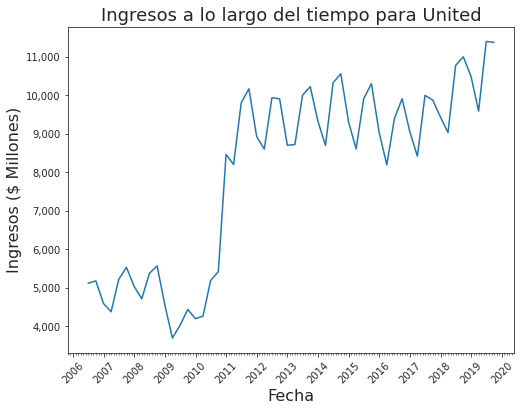

In [14]:
def plot_time_series(dates, values, title, x_label, y_label):#SE CREA UNA FUNCIÓN MUY SENCILLA PARA SABER CÓMO AFRONTAR EL PROBLEMA
    """
    dates: must be a datetime series for the x axis #Localice el año y el mes y conviertalo en un valor
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """
    #CON EL SIGUIENTE PASO LO QUE QUEREMOS ES LOCALIZAR EL AÑO Y EL MES Y CONVERTIRLO EN UN FORMATO DE FECHA
    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates, y=values, ci=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()
    
united_revenues['DATE'] = united_revenues.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), int(r['DAY'])), axis=1)
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'Ingresos a lo largo del tiempo para United', 'Fecha', 'Ingresos ($ Millones)')

<p>Algo que notamos es el comportamiento cíclico estacional, la disminución de la demanda en enero y un repunte en 2011 causado por la fusión de dos aerolíneas.</p>

<p>Vamos a repetir el análisis para <code>airline_fuel_cost.csv</code>. Verá muchas variables; por el bien del ejercicio, sólo estamos interesados en <strong>QUARTER</strong> y <strong>TOTAL_COST</strong>.</p>

In [5]:
airline_costs = pd.read_csv('./airline_fuel_costs.csv')#CAMBIAMOS DE ARCHIVO PARA EL ANÁLISIS
airline_costs

,YEAR,QUARTER,MONTH,AIRLINE_ID,UNIQUE_CARRIER,CARRIER,CARRIER_NAME,CARRIER_GROUP_NEW,SALA_GALLONS,SDOM_GALLONS,...,NDOMT_COST,NATL_COST,NPAC_COST,NLAT_COST,MAC_COST,NINT_COST,TN_COST,TDOMT_COST,TINT_COST,TOTAL_COST
0,2010,1,1,20397.0,OH,16,PSA Airlines Inc.,2,0.0,4719365.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10794066.0,62257.0,10856323.0
1,2010,1,1,20408.0,5V,3Z,Tatonduk Outfitters Limited d/b/a Everts Air A...,1,192411.0,0.0,...,54369.0,0.0,0.0,0.0,0.0,0.0,54369.0,754533.0,0.0,754533.0
2,2010,1,1,19917.0,5X,5X,United Parcel Service,3,0.0,28998000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62149000.0,55870000.0,118019000.0
3,2010,1,1,20007.0,5Y,5Y,Atlas Air Inc.,3,0.0,21075.0,...,4459908.0,8895515.0,11296181.0,6180995.0,12056524.0,38429215.0,42889123.0,4514818.0,39381611.0,43896429.0
4,2010,1,1,19874.0,8C,8C,Air Transport International,2,0.0,0.0,...,5659367.0,154290.0,0.0,154290.0,3069324.0,3377904.0,9037271.0,5659367.0,3377904.0,9037271.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588,2019,2,5,19393.0,WN,WN,Southwest Airlines Co.,3,0.0,177347813.0,...,200727.0,0.0,0.0,0.0,0.0,0.0,200727.0,371853619.0,6309955.0,378163574.0
6589,2019,2,6,19393.0,WN,WN,Southwest Airlines Co.,3,0.0,176316720.0,...,200836.0,0.0,0.0,0.0,0.0,0.0,200836.0,351593930.0,6375770.0,357969700.0
6590,2019,3,7,19393.0,WN,WN,Southwest Airlines Co.,3,0.0,182539375.0,...,216975.0,0.0,0.0,0.0,0.0,0.0,216975.0,362654100.0,5797137.0,368451237.0
6591,2019,3,8,19393.0,WN,WN,Southwest Airlines Co.,3,0.0,175218927.0,...,99567.0,0.0,0.0,0.0,0.0,0.0,99567.0,342904670.0,3911530.0,346816200.0


In [6]:
# solo obtenga ingresos de United
united_costs = airline_costs[airline_costs['UNIQUE_CARRIER'] == 'UA']

# solo mantenga columnas relevantes
columns_to_keep = ['YEAR', 'QUARTER', 'MONTH', 'TOTAL_COST']
united_costs = united_costs[columns_to_keep]
united_costs

,YEAR,QUARTER,MONTH,TOTAL_COST
47,2010,1,1,320169235.0
106,2010,1,2,278634843.0
165,2010,1,3,339915313.0
224,2010,2,4,348193934.0
283,2010,2,5,385441906.0
...,...,...,...,...
6380,2019,2,5,653718728.0
6430,2019,2,6,628169636.0
6480,2019,3,7,645067356.0
6529,2019,3,8,626433174.0


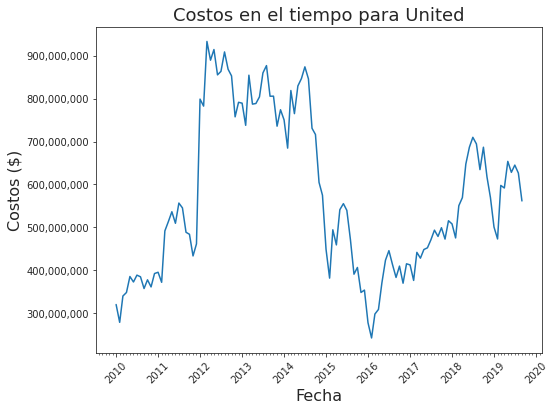

In [7]:
united_costs['DATE'] = united_costs.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), 1), axis=1)
plot_time_series(united_costs['DATE'], united_costs['TOTAL_COST'], 'Costos en el tiempo para United', 'Fecha', 'Costos ($)')

<p>Para completar el análisis, ahora veremos el precio de los productos derivados del petróleo a través del archivo <code>oil.csv</code>:</p>

In [8]:
oil_prices = pd.read_csv('./oil.csv')
oil_prices['DATE'] = pd.to_datetime(oil_prices['DATE'])
oil_prices

,DATE,NY_GASOLINE_PRICE,US_GASOLINE_PRICE,YEAR,MONTH,KEROSENE_PRICE
0,1990-04-01,0.600,0.617,1990,4,0.540
1,1990-05-01,0.643,0.667,1990,5,0.515
2,1990-06-01,0.646,0.613,1990,6,0.494
3,1990-07-01,0.653,0.602,1990,7,0.535
4,1990-08-01,0.897,0.866,1990,8,0.791
...,...,...,...,...,...,...
352,2019-08-01,1.694,1.690,2019,8,1.800
353,2019-09-01,1.726,1.681,2019,9,1.874
354,2019-10-01,1.728,1.646,2019,10,1.861
355,2019-11-01,1.724,1.636,2019,11,1.824


<p>A partir de esto, podemos ver que tenemos los precios de 3 productos petroleros diferentes al comienzo de cada mes. Grafiquémoslos para ver la diferencia.</p>

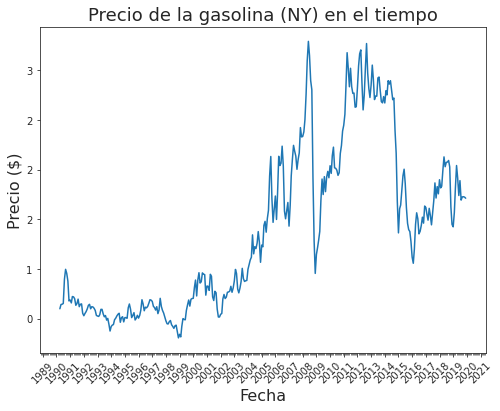

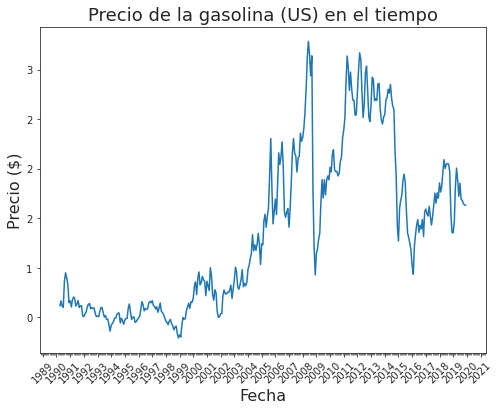

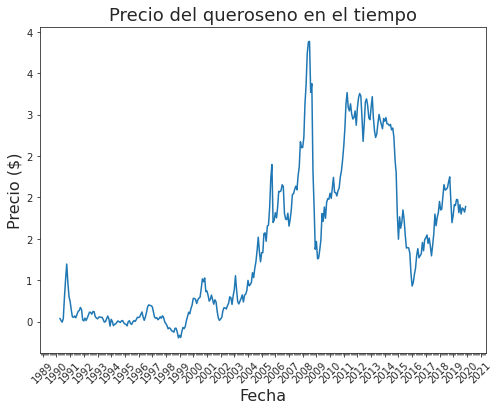

In [9]:
plot_time_series(oil_prices['DATE'], oil_prices['NY_GASOLINE_PRICE'], 'Precio de la gasolina (NY) en el tiempo', 'Fecha', 'Precio ($)')
plot_time_series(oil_prices['DATE'], oil_prices['US_GASOLINE_PRICE'], 'Precio de la gasolina (US) en el tiempo', 'Fecha', 'Precio ($)')
plot_time_series(oil_prices['DATE'], oil_prices['KEROSENE_PRICE'], 'Precio del queroseno en el tiempo', 'Fecha', 'Precio ($)')

<p>A partir de esto, podemos ver que todos ellos están altamente correlacionados con variaciones menores. Para nuestro deleite, también está altamente correlacionado con los costos de las aerolíneas generados anteriormente. A los efectos de este estudio, debería ser suficiente elegir uno de ellos.</p>

<h3>Pregunta:</h3>
<p>¿Cuál deberíamos elegir?</p>

El queroseno es lo que usan los aviones para volar y, por lo tanto, debería ser el foco. Siempre es importante elegir variables que tengan relaciones causales lo más claras posible con lo que estamos pronosticando. Este tipo de uso del conocimiento del dominio es crucial para evitar la minería de datos para buscar correlaciones en lugar de causas.

In [10]:
columns_to_keep = ['YEAR', 'MONTH', 'DATE', 'KEROSENE_PRICE']
oil_prices = oil_prices[columns_to_keep]
oil_prices

,YEAR,MONTH,DATE,KEROSENE_PRICE
0,1990,4,1990-04-01,0.540
1,1990,5,1990-05-01,0.515
2,1990,6,1990-06-01,0.494
3,1990,7,1990-07-01,0.535
4,1990,8,1990-08-01,0.791
...,...,...,...,...
352,2019,8,2019-08-01,1.800
353,2019,9,2019-09-01,1.874
354,2019,10,2019-10-01,1.861
355,2019,11,2019-11-01,1.824


<p>En general, pero especialmente en el caso de las series temporales, es importante recordar estos procedimientos de recopilación de datos. En este caso, tenemos 3 series de tiempo: ingresos, costos y precios del petróleo. Como sabemos que la ganancia es simplemente una función de los costos, sería tentador tirar los precios del petróleo. ¿Por qué nos importa el precio de un insumo en el costo cuando tenemos el costo real? La respuesta está en la demora entre el momento en que se recopilan los datos y lo que realmente sucede en un momento dado. Para este caso:</p>
<ol>
<li><strong>Ingresos de la aerolínea:</strong> Los ingresos trimestrales presentados por la aerolínea a la SEC</li>
<li><strong>Costos de la aerolínea:</strong> Estos datos tardan en adquirirse y su empresa tarda 3 meses en calcular los costes. Así, si estamos en diciembre, tienes todos los gastos hasta septiembre de ese año.</li>
<li><strong>Precios del petróleo:</strong> Este es un precio en vivo que se negocia públicamente. En cualquier momento dado, sabemos exactamente el precio del queroseno</li>
</ol>

<p>¿Cómo encajan estas piezas con respecto a nuestro objetivo y qué información nos falta?</p>

Nuestro objetivo es predecir los ingresos. Sin embargo, todo lo que tenemos es información sobre los costos del pasado. Esto puede parecernos inútil, pero los costos son casi lo mismo que los ingresos. Si hacemos una gran suposición (recuerde sus suposiciones) de que los ingresos/pasajero y el costo/pasajero son aproximadamente constantes a corto plazo, entonces el costo es un buen predictor de ingresos. Entonces, nuestro modelo inicial, dados nuestros datos existentes se parece a:

$$\text{Ingresos} = f(\text{Costos anteriores})$$

Pero esto no tiene en cuenta nada en el presente. Además, sabemos que los ingresos están directamente relacionados con la cantidad de personas que vuelan en la aerolínea. Dada nuestra suposición, si pudiéramos incorporar el número de pasajeros, entonces este sería un muy buen modelo:

$$\text{Ingresos} = f(\text{Costos anteriores},\text{Número de pasajeros})$$

Esto nos guía para complementar nuestros datos actuales tratando de encontrar una buena medida del número actual de pasajeros en una aerolínea.

-------

<h2>Complementando con los datos BTS</h2>
<p>Ahora que sabemos que queremos obtener una predicción de la cantidad probable de pasajeros en una aerolínea, sería bueno encontrar un conjunto de datos de la cantidad histórica de pasajeros de las aerolíneas. Después de buscar en Internet, encontramos la fuente de datos perfecta de <a href="https://www.transtats.bts.gov/Tables.asp?DB_ID=111&amp;DB_Name=Air%20Carrier%20Statistics%20%28Form%2041%20Traffic%29-%20All%20Carriers&amp;DB_Short_Name=Air%20Carriers">Oficina de Estadísticas de Transporte</a>. Es decir, el conjunto de datos del mercado nacional T-100 (transportistas estadounidenses) contiene los siguientes atributos:</p>
<ol>
<li><strong>PASSENGERS:</strong> El número de pasajeros en el segmento de vuelo.</li>
<li><strong>UNIQUE_CARRIER:</strong> El código de identificación del transportista</li>
<li><strong>ORIGIN_AIRPORT_ID:</strong> El ID del aeropuerto de origen</li>
<li><strong>DEST_AIRPORT_ID:</strong> El ID del aeropuerto de destino</li>
<li><strong>YEAR:</strong> Año del vuelo</li>
<li><strong>MONTH:</strong> Mes del vuelo</li>
<li><strong>QUARTER:</strong> Trimestre del vuelo</li>
</ol>
<p>La forma en que se organizan los datos es que agregan el número de pasajeros mensuales agrupados por aerolínea, así como por aeropuertos de origen y destino. Es decir, cada fila representa a todos los pasajeros que volaron entre dos ciudades durante un mes y una aerolínea determinados. Mirando los datos que ya tiene, decide que solo usará la información desde 2012, ya que este es el primer año de operación que United hizo en la forma que conocemos hoy. Los datos brutos están disponibles en <code>airline_passengers.csv</code>. Investiguemos cómo se ve este conjunto de datos:</p>

In [11]:
airline_passengers = pd.read_csv('./airline_passengers.csv')
airline_passengers

FileNotFoundError: ignored

<h3>Visualizando los datos</h3>
<p>Ahora vamos a visualizar estos datos. Realmente sería bueno visualizar todo en un mapa para confirmar que los datos son precisos. El DataFrame que se muestra arriba sería una pesadilla para tratar de analizar sin una mayor transformación.</p>
<p>Lo primero que notamos es que hay muchos datos aquí y sería bueno saber a qué aeropuertos corresponden esos ID. Como solo estamos interesados en United, eso debería manejar muchas de las filas. Para los aeropuertos, también encontraste <a href="https://www.transtats.bts.gov/FieldInfo.asp?Field_Desc=An%20identification%20number%20assigned%20by%20US%20DOT%20to%20identify%20a%20unique%20airline%20%28carrier%29.%20A%20unique%20airline%20%28carrier%29%20is%20defined%20as%20one%20holding%20and%20reporting%20under%20the%20same%20DOT%20certificate%20regardless%20of%20its%20Code%2C%20Name%2C%20or%20holding%20company/corporation.&amp;Field_Type=Num&amp;Lookup_Table=L_AIRLINE_ID&amp;Table_ID=292&amp;SYS_Table_Name=T_T100_MARKET_ALL_CARRIER&amp;Sys_Field_Name=AIRLINE_ID">esto</a> en la documentación del sitio web de BTS, que nos ayudará a determinar qué aeropuertos son cuáles. Además, también da la <code>LAT</code> and <code>LON</code> (latitud y longitud) para cada aeropuerto que nos ayudará con visualizaciones de mapas:</p>

In [ ]:
united_passengers = airline_passengers[airline_passengers['UNIQUE_CARRIER'] == 'UA']
united_passengers

In [ ]:
airports = pd.read_csv('airports.csv')
airports

<p>Como podemos ver, hay muchos aeropuertos diferentes y muchos de ellos son bastante pequeños con ubicaciones desconocidas (por ejemplo, "Punto desconocido en Alaska"). También vemos que algunos aeropuertos tienen listas de <code>NaN</code> para su ubicación. Intentemos filtrar los aeropuertos a los que United no vuela y esperemos que todas las filas restantes tengan sus ubicaciones en la lista. Primero, necesitamos los aeropuertos únicos:</p>

In [ ]:
unique_airports = set(list(united_passengers['ORIGIN_AIRPORT_ID'].unique()))
unique_airports.update(list(united_passengers['DEST_AIRPORT_ID'].unique()))
len(unique_airports)

<p>Ahora, restrinjamos el marco de datos de los aeropuertos a aquellos a los que vuela United y veamos si alguno de ellos es nulo:</p>

In [ ]:
united_airports = airports[airports['Code'].isin(list(unique_airports))]
united_airports[united_airports['LAT'].isnull()]

<p>Desafortunadamente, muchos de ellos son nulos y algunos de ellos son grandes aeropuertos (George Bush Intercontinental en Houston es un gran centro). qué hacemos?</p>
<p>Resulta que podemos usar el paquete <a href="https://geopy.readthedocs.io/en/stable/">GeoPy</a> para capturar ubicaciones dadas direcciones. (En general, esta es una buena práctica; cuando tenga un problema con sus datos, sea ingenioso para conectarse en línea y buscar algo que pueda ayudarlo a resolver su problema. No reinvente la rueda ni suponga, por el contrario, que no hay nada tu puedes hacer.)</p>
<p>La parte mala es que las direcciones en el DataFrame no están realmente estandarizadas. Sería muy bueno si tuviéramos el código internacional IATA de 3 letras para cada aeropuerto. Afortunadamente para nosotros, BTS lo proporciona <a href="https://www.bts.gov/topics/airlines-and-airports/world-airport-codes">aquí</a>. Convirtamos esta tabla HTML en un DataFrame de <code>pandas</code>:</p>

In [ ]:
airport_codes = pd.read_html('https://www.bts.gov/topics/airlines-and-airports/world-airport-codes')[0]
airport_codes

<p>Ahora podemos fusionar esto fácilmente y encontrar las ubicaciones usando <code>GeoPy</code> de la siguiente manera:</p>

In [ ]:
geolocator = Nominatim(user_agent="Airport Lat/Long Finder", timeout=100)
geolocator.geocode('IAH airport TX')

<p>Primero, fusionemos el conjunto de datos <code>united_airports</code> con el conjunto de datos de códigos IATA. Luego, usando <code>GeoPy</code>, escribiremos una función para asignar las latitudes y longitudes faltantes de los aeropuertos a los que vuela United.</p>

In [ ]:
united_airports = united_airports.merge(airport_codes, left_on='Description', right_on='City: Airport', suffixes=('_BTS', '_IATA'))
united_airports

In [ ]:
def get_airport_lat_long_by_iata_code(code, state):

    geolocator = Nominatim(user_agent="Airport Lat/Long Finder", timeout=100)
    code += ' airport '
    code += state
        
    try:    
        lat_long = geolocator.geocode(code)
        if lat_long:
            
            return str(lat_long.latitude), str(lat_long.longitude)
        else:
            return None, None
    except:
            print('Error reading ' + name)
            return None, None
        
    # necesario para evitar errores de rastreo
    time.sleep(1)
        
lat_lons = united_airports[united_airports['LAT'].isnull()].apply(lambda r: get_airport_lat_long_by_iata_code(r['Code_IATA'], r['Description'].split(':')[0].split(',')[-1]), axis=1)

In [ ]:
for i in lat_lons.index:
    united_airports['LAT'].loc[i] = lat_lons.loc[i][0]
    united_airports['LON'].loc[i] = lat_lons.loc[i][1]
united_airports

<h3>Trazar los vuelos en un mapa</h3>
<p>Ahora, usando <a href="https://plotly.com/">Plotly</a> podemos visualizar los datos. Primero, necesitamos el <code>LAT</code> y <code>LON</code> para cada aeropuerto <code>ORIGIN</code> y <code>DEST</code>:</p>

In [ ]:
united_paths = united_passengers.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'UNIQUE_CARRIER', 'YEAR', 'MONTH'])['PASSENGERS'].sum().reset_index()
united_paths = united_paths.merge(airports, left_on='ORIGIN_AIRPORT_ID', right_on='Code')
united_paths = united_paths.merge(airports, left_on='DEST_AIRPORT_ID', right_on='Code', suffixes=("_ORIGIN", "_DEST"))
united_paths

In [ ]:
def plot_flight_paths(paths, airports):
    fig = go.Figure()

    tmp = paths.groupby(['LAT_ORIGIN', 'LON_ORIGIN', 'LAT_DEST', 'LON_DEST']).sum().reset_index()
    max_passengers = float(tmp['PASSENGERS'].max())

    for index, path in tmp.iterrows():
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [path['LON_ORIGIN'], path['LON_DEST']],
                lat = [path['LAT_ORIGIN'], path['LAT_DEST']],
                mode = 'lines',
                hoverinfo = "none",
                line = dict(width = 2, color = 'rgb(0, 93, 170)'),
                opacity = path['PASSENGERS'] / max_passengers,
            )
        )

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airports['LON'],
        lat = airports['LAT'],
        hoverinfo = 'text',
        text = airports['Description'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = 'Flights by United',
        font = {'size':36},
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'north america',
            projection_type = 'kavrayskiy7',
            showland = True,
            showlakes = True,
            showcountries = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
    fig.show()
    
plot_flight_paths(united_paths[united_paths['YEAR'] == 2012], united_airports)

<p>¿Qué está haciendo Hawái en la ubicación de Hong Kong? En este caso, si lee la documentación en el sitio web de BTS, reafirmaría que simplemente es una latitud y longitud incorrectas. Cambiemos esos para los vuelos LIH:</p>

In [ ]:
def replace_lat_lon(r, lat_or_lon, origin_or_dest):
    """
    lat_or_lon: LAT or LON
    origin_or_dest: ORIGIN or DEST
    """
    
    LIH_code = 12982
    LIH_lat, LIH_lon = 21.976111, -159.338889
    
    copy_column = lat_or_lon + '_'
    copy_column += origin_or_dest
    
    code_column = 'Code_' + origin_or_dest
    
    if r[code_column] == LIH_code:
        return LIH_lat if lat_or_lon == 'LAT' else LIH_lon
    else:
        return r[copy_column]
    

united_paths['LAT_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "ORIGIN"), axis=1)
united_paths['LON_ORIGIN'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "ORIGIN"), axis=1)
united_paths['LAT_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LAT', "DEST"), axis=1)
united_paths['LON_DEST'] = united_paths.apply(lambda r: replace_lat_lon(r, 'LON', "DEST"), axis=1)

<p>Modificaremos la función de graficación anterior para tomar el año y comparar los vuelos de United de 2012, 2015 y 2019. ¿Cuáles son algunas de las tendencias que observa?</p>

<p>Como se esperaba, vemos un aumento general en el número de pasajeros a lo largo del tiempo. Una cosa interesante que notamos es el grupo de vuelos en el Pacífico Sur. Esto se debe al monopolio que tiene United de volar a Guam. También podemos ver que se eliminan y agregan rutas de vuelo individuales (por ejemplo, la de Puerto Rico). Sin embargo, la principal tendencia general es el aumento de vuelos al sur, como en Texas y Florida. Esto tiene sentido porque el corredor NYC-LA ha estado bastante ocupado durante mucho tiempo con poco espacio para el crecimiento </p>

In [ ]:
def plot_flight_paths(paths, airports, year):
    fig = go.Figure()
    
    tmp = paths.groupby(['LAT_ORIGIN', 'LON_ORIGIN', 'LAT_DEST', 'LON_DEST', 'YEAR']).sum().reset_index()
    
    max_passengers = float(tmp['PASSENGERS'].max())
    tmp = tmp[tmp['YEAR'] == year]

    for index, path in tmp.iterrows():
        fig.add_trace(
            go.Scattergeo(
                locationmode = 'USA-states',
                lon = [path['LON_ORIGIN'], path['LON_DEST']],
                lat = [path['LAT_ORIGIN'], path['LAT_DEST']],
                mode = 'lines',
                hoverinfo = "none",
                line = dict(width = 2, color = 'rgb(0, 93, 170)'),
                opacity = path['PASSENGERS']**1.5 / max_passengers**1.5,
            )
        )


    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = airports['LON'],
        lat = airports['LAT'],
        hoverinfo = 'text',
        text = airports['Description'],
        mode = 'markers',
        marker = dict(
            size = 2,
            color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.update_layout(
        title_text = 'Flights by United',
        font = {'size':36},
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'north america',
            projection_type = 'kavrayskiy7',
            showland = True,
            showlakes = True,
            showcountries = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
    fig.show()

In [ ]:
plot_flight_paths(united_paths, united_airports, 2012)

In [ ]:
plot_flight_paths(united_paths, united_airports, 2015)

In [ ]:
plot_flight_paths(united_paths, united_airports, 2019)

<h3>Pasajeros e ingresos</h3>
<p>Esto completa nuestra EDA básica sobre los datos BTS. El punto que debe enfatizarse es que esta EDA se utilizó únicamente como un medio para validar los datos. Todavía no podemos extraer hipótesis sobre los ingresos a partir de los datos de los pasajeros. Recuerda que no tenemos esta información hasta 3 meses después del hecho. Sin embargo, si lo hiciéramos, deberíamos asegurarnos de que esta sea una información útil.</p>
<p>Cuando se trata de series temporales, es importante ocuparse de las tendencias. Si dos series están predominantemente dominadas por una tendencia, entonces sus fluctuaciones individuales se pierden y esto puede llevar a una conclusión falsa. Considere el siguiente ejemplo de dos líneas aleatorias:</p>

In [ ]:
def plot_series_with_slope(m):
    n = 100
    t = np.linspace(0, n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)

    sns.lineplot(t, X_1)
    sns.lineplot(t, X_2)

def get_corr_with_slope(m):
    n = 100
    t = np.linspace(0, 10*n, n)

    X_1 = m*t + np.random.normal(size=n)
    X_2 = m*t + np.random.normal(size=n)
    
    return np.corrcoef(X_1, X_2)

plot_series_with_slope(0)

<p>A simple vista, estas series parecen increíblemente no relacionadas. Medir su correlación confirma esto:</p>

In [ ]:
get_corr_with_slope(0)

<p>Sin embargo, ¿qué pasa si aumentamos la pendiente entre ellos?:</p>

In [ ]:
plot_series_with_slope(0.1)
get_corr_with_slope(0.1)

<p>Como puede ver, la correlación es casi perfecta. Para darle una idea de qué tan rápido la tendencia puede dominar la relación, aquí está la correlación en función del tamaño de la pendiente:</p>

In [ ]:
slopes = np.logspace(-6,1,100)
corrs = []

for m in slopes:
    corrs.append(get_corr_with_slope(m)[0,1])
    
f, ax = plt.subplots()
ax.set(xscale='log')
sns.lineplot(x=slopes, y=corrs)

<p>A la luz de este hecho, necesitamos eliminar la tendencia de esta línea. Esto se hace fácilmente correlacionando la diferencia entre puntos:</p>

In [ ]:
m = 1
n = 1000
t = np.linspace(0, 10*n, n)

X_1 = pd.Series(m*t + np.random.normal(size=n))
X_2 = pd.Series(m*t + np.random.normal(size=n))

def time_series_corr(X_1, X_2):
    
    diff_1 = X_1[1:]-X_1.shift()[1:]
    diff_2 = X_2[1:]-X_2.shift()[1:]
    
    return np.corrcoef(diff_1, diff_2)

time_series_corr(X_1, X_2)

<p>Ahora que podemos correlacionar dos series temporales, veamos cómo se correlacionan los pasajeros y los ingresos. Lo primero que necesitamos es fusionar los DataFrames de ingresos y pasajeros. Tal como está, nuestro DataFrame de pasajeros tiene una fila para cada aeropuerto de origen y de destino, para cada mes. Entonces, necesitamos agregar estos números para cada mes. Sin embargo, los ingresos solo salen cada trimestre, por lo que también agregaremos el trimestre al DataFrame de pasajeros:</p>

In [ ]:
united_passengers_by_month = united_passengers.groupby(['YEAR', 'MONTH']).sum()['PASSENGERS'].reset_index()
united_passengers_by_month['DATE'] = united_passengers_by_month.apply(lambda r: datetime(int(r['YEAR']), int(r['MONTH']), 1), axis=1)
united_passengers_by_month

In [ ]:
plot_time_series(united_passengers_by_month['DATE'], united_passengers_by_month['PASSENGERS'], 'Pasajeros de United en el tiempo', 'Fecha', 'Pasajeros')
plot_time_series(united_revenues['DATE'], united_revenues['REVENUE'], 'Ingresos de United en el tiempo', 'Fecha', 'Ingresos ($)')

<p>Antes de que podamos correlacionar estas series, debemos unirnos en el trimestre para que los DataFrames coincidan en granularidad:</p>

In [ ]:
united_passengers_by_quarter = united_passengers.groupby(['YEAR', 'QUARTER']).sum()['PASSENGERS'].reset_index()
united_passengers_by_quarter

In [ ]:
united_revenues['QUARTER'] = united_revenues.apply(lambda r: int(r['MONTH']//3), axis=1)
merged_df = pd.merge(united_revenues, united_passengers_by_quarter, on=['YEAR', 'QUARTER'])
time_series_corr(merged_df['REVENUE'], merged_df['PASSENGERS'])

<p>A partir de esto, podemos ver que los pasajeros están extremadamente correlacionados con los ingresos. Por lo tanto, conocer el número de pasajeros proporciona una señal de alta calidad para predecir los ingresos. Sin embargo, todavía tenemos el problema de la información retrasada. ¿Puede pensar en algunas fuentes de datos que podrían brindarnos información hasta el presente?</p>

<h2>Datos de Twitter</h2>
<p>Para solucionar el problema del retraso, intentaremos predecir la cantidad actual de pasajeros que utilizan Twitter. Específicamente, planteamos la hipótesis de que la cantidad de tweets en un mes determinado está correlacionada con los pasajeros de ese mes. El Twitter de United se puede encontrar en <code>united_tweets.csv</code> y tiene las siguientes características simples:</p>
<ol>
<li><strong>COUNT:</strong> La cantidad de tuits en Twitter que tenían United etiquetados en ellos</li>
<li><strong>DATE:</strong> La fecha de los tuits.</li>
</ol>

In [ ]:
united_tweets = pd.read_csv('./united_tweets.csv')
united_tweets

<p>Ahora verificamos si estos tweets están correlacionados con los pasajeros agregando los tweets por mes:</p>

In [ ]:
united_tweets['DATE'] = pd.to_datetime(united_tweets['DATE'])
united_tweets['YEAR'] = united_tweets['DATE'].dt.year
united_tweets['MONTH'] = united_tweets['DATE'].dt.month
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH']).sum().reset_index()
united_tweets_by_month

In [ ]:
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

<p>Desafortunadamente, este es un resultado increíblemente decepcionante. Vamos a ver si podemos averiguar lo que está pasando:</p>

In [ ]:
plot_time_series(united_tweets['DATE'], united_tweets['COUNT'], 'Tweets asociados a United en el tiempo', 'Date', 'Number of Tweets')

<p>Esa es una anomalía increíblemente grande. Vamos a ver.</p>

In [ ]:
united_tweets[united_tweets['COUNT'] > 300000]

Una revisión rápida de Google mostrará que United tuvo un incidente notorio el 10 de abril de 2017.

¿Cómo debemos manejar la anomalía?

Deberíamos realizar algún tipo de suavizado sobre la serie temporal. Hay muchos tipos de suavizado que podemos hacer:

+ Simplemente elimine las anomalías o reemplácelas con el valor esperado.
+ Podemos aplicar una media "móvil". es decir, tome el recuento promedio de los últimos 30 días. Incluso podríamos aplicar la mediana en lugar de la media.
+ Agregue los datos por mes.

Todas estas son opciones excelentes, pero tendremos que medir objetivamente cuál es la mejor.

<h3>Ingeniería de características de nuestros datos de Twitter</h3>
<p>Antes de comenzar con la ingeniería de características, necesitamos una forma de cuantificar la utilidad de lo que estamos tratando de lograr. En este caso, estamos buscando una señal que esté altamente correlacionada con los datos de pasajeros de United. Aunque nuestro objetivo es predecir los ingresos, la idea general es usar los datos de los pasajeros para predecir los ingresos y luego usar los datos de Twitter para predecir los datos de pasajeros más recientes. Por lo tanto, utilizaremos nuestra función <code>time_series_corr()</code> en nuestra característica diseñada y los datos mensuales de pasajeros para cuantificar su utilidad.</p>
<p>Primero, comenzaremos con un promedio móvil simple de los últimos treinta días. Usaremos la función <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html"><code>rolling()</code></a> de <code>pandas</code>. La función <code>rolling()</code> es muy similar a la función <code>groupby()</code>. Esencialmente "agrupa" las filas de forma continua.:</p>

In [ ]:
n_days = 30

united_tweets['SMA'] = united_tweets['COUNT'].rolling(n_days).mean()
united_tweets

<p>Grafiquémoslo y valoremos su utilidad:</p>

In [ ]:
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['SMA'].iloc[n_days:], 'SMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['SMA'], united_passengers_by_month['PASSENGERS'])

<p>Lo bueno de la función <code>rolling()</code> es que permite aplicar diferentes pesos a la ventana móvil. Por ejemplo, si desea privilegiar los puntos de datos más recientes, todo lo que tiene que hacer es proporcionar el argumento <code>win_type</code>. Consulte el enlace de documentación anterior para ver todos los diferentes tipos de ventanas. O bien, puede utilizar la función <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html"><code>ewm()</code></a> si quiere una media móvil exponencial:</p>

In [ ]:
alpha = 0.5
united_tweets['EMA'] = united_tweets['COUNT'].ewm(alpha=alpha).mean()
plot_time_series(united_tweets['DATE'], united_tweets['EMA'], 'EMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.groupby(['YEAR', 'MONTH']).mean()['EMA'], united_passengers_by_month['PASSENGERS'])

<p>Como puede ver, esto sigue siendo decepcionante. La causa raíz es el fuerte pico de 2017. ¿Existe otra función de agregación que sea más dura para los grandes picos? ¡Sí! La función mediana:</p>

In [ ]:
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['MMA'], united_passengers_by_month['PASSENGERS'])

<p>¡Ahora estamos haciendo algunos progresos! Pero los picos siguen siendo problemáticos. Si aplicamos la mediana sobre un rango mayor, los picos desaparecen:</p>

In [ ]:
n_days = 60
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['MMA'].iloc[n_days:], 'MMA of United Tweets', 'Date', 'Number of Tweets')

<p>Sin embargo, el problema es que estamos limitados por el tamaño de la ventana porque entonces empezamos a perder información de las estaciones. Una cosa fácil que podemos hacer es tomar la mediana de la mediana móvil:</p>

In [ ]:
n_days = 30
united_tweets['MMA'] = united_tweets['COUNT'].rolling(n_days).median()

# need to convert tweets to month
time_series_corr(united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).median()['MMA'], united_passengers_by_month['PASSENGERS'])

<p>Una vez más, algo de progreso, pero los picos aún deben solucionarse. ¿Qué pasa si agrupamos por mes primero en lugar de hacer una ventana móvil?:</p>

In [ ]:
united_tweets_by_month = united_tweets.groupby(['YEAR', 'MONTH'])['COUNT'].median().reset_index()
plot_time_series(united_passengers_by_month['DATE'], united_tweets_by_month['COUNT'], 'Monthly Median of United Tweets', 'Date', 'Number of Tweets')
time_series_corr(united_tweets_by_month['COUNT'], united_passengers_by_month['PASSENGERS'])

<p>Eso es un paso atrás, pero sigue siendo un esfuerzo valiente.</p>

Intentemos diseñar la serie temporal de los tweets para eliminar los picos grandes y superar la correlación de  0.2  que arrojó la ventana móvil mediana.

In [ ]:
n_days = 30
slope, coef = np.polyfit(united_tweets.index, united_tweets['COUNT'], 1)
std = united_tweets['COUNT'].std()

def smooth_count(r):
    count = r['COUNT']
    t = r.name
    
    if count > t*slope + coef + 0.05*std:
        return t*slope + coef
    else:
        return count


united_tweets['SMOOTH_COUNT'] = united_tweets.apply(lambda r: smooth_count(r), axis=1)

plot_time_series(united_tweets['DATE'], united_tweets['SMOOTH_COUNT'], 'Conteo suavizado de Tweets de United', 'Fecha', 'Número de Tweets')

# Ahora aplique la mediana móvil
united_tweets['SMOOTH_SMA'] = united_tweets['SMOOTH_COUNT'].rolling(n_days).mean()
plot_time_series(united_tweets['DATE'].iloc[n_days:], united_tweets['SMOOTH_SMA'].iloc[n_days:], 'SMA suavizado de Tweets de United', 'Fecha', 'Número de Tweets')

# necesidad de convertir tweets al mes
united_tweets_by_month = united_tweets.iloc[n_days:].groupby(['YEAR', 'MONTH']).mean()['SMOOTH_SMA'].reset_index()
time_series_corr(united_tweets_by_month['SMOOTH_SMA'], united_passengers_by_month['PASSENGERS'])

<h2>Construyendo el modelo</h2>
<p>Ahora que tenemos todos nuestros datos, resumamos lo que tenemos:</p>
<p><strong>Variables independientes:</strong></p>
<ol>
<li>Pasajeros de aerolíneas: último disponible, hace 3 meses - <code>united_passengers_by_month</code></li>
<li>Costos de aerolíneas: último disponible, hace 3 meses - <code>united_costs</code></li>
<li>Costos del petróleo: último disponible, presente - <code>oil_prices</code></li>
<li>Recuento de tweets: último disponible, presente - <code>united_tweets_by_month</code></li>
</ol>
<p><strong>Variable objetivo:</strong></p>
<ol>
<li>Ingresos: Disponible cada trimestre</li>
</ol>
<p>Todo es una serie temporal, por lo que debemos decidir cuánto historial queremos incluir en el algoritmo. Tener más historial debería ayudar con mejores predicciones, pero la mayor parte de la información útil se encuentra en el historial cercano. También tenemos que decidir qué variables incluir. Aquí hay dos ejemplos:</p>
<p>$Ingresos_i = f(Pasajeros_{i-3}, Costos_{i-2}, Queroseno_i, Tweets_i)$</p>
<p>Esto representa usar solo los últimos pasajeros, costos y tweets. En el otro extremo del espectro, podríamos tener algo como:</p>
<p>$Ingresos_i = f(Pasajeros_{i-3}, Pasajeros_{i-4}, Pasajeros_{i-5}, Pasajeros_{i-6}, Pasajeros_{i-7}, Pasajeros_{i-8}, Pasajeros_{i-9}, Pasajeros_{i-10}, Pasajeros_{i-11}, Pasajeros_{i-12}, Pasajeros_{i-13}, Pasajeros_{i-14}, Costos_{i-2}, Costos_{i-3}, Costos_{i-4}, Costos_{i-5}, Costos_{i-6}, Costos_{i-7}, Costos_{i-8}, Costos_{i-9}, Costos_{i-10}, Costos_{i-11}, Costos_{i-12}, Costos_{i-13}, Costos_{i-14}, Queroseno_{i}, Queroseno_{i-1}, Queroseno_{i-2}, Queroseno_{i-3}, Queroseno_{i-4}, Queroseno_{i-5}, Queroseno_{i-6}, Queroseno_{i-7}, Queroseno_{i-8}, Queroseno_{i-9}, Queroseno_{i-10}, Queroseno_{i-11}, Tweets_{i}, Tweets_{i-1}, Tweets_{i-2}, Tweets_{i-3}, Tweets_{i-4}, Tweets_{i-5}, Tweets_{i-6}, Tweets_{i-7}, Tweets_{i-8}, Tweets_{i-9}, Tweets_{i-10}, Tweets_{i-11})$</p>
<p>que incluiría los últimos 12 meses de datos para cada serie temporal que tenemos. Evaluemos ambos modelos. Primero, necesitamos introducir <strong>variables retrasadas</strong> en nuestros datos usando la función <code>shift()</code> de <code>pandas</code> :</p>

In [ ]:
oil_prices[['KEROSENE_PRICE']]

In [ ]:
oil_prices[['KEROSENE_PRICE']].shift(1)

<p>Finalmente, tenemos que fusionar estos DataFrames rezagados con nuestra variable objetivo y crear variables ficticias para los trimestres de la declaración de ingresos. Aquí se utilizan variables ficticias porque los trimestres no son ordinales. Es decir, si el efecto de los ingresos en el primer trimestre es $\beta$, entonces el efecto en el cuarto trimestre <strong>no</strong> será $4\beta$:</p>

In [ ]:
def make_lag_dfs(num_oil_lag, num_passengers_lag, num_costs_lag, num_tweets_lag):
    X = pd.DataFrame()

    start_date = datetime(2012,1,1)
    end_date = datetime(2020,1,1)

    X = oil_prices[(oil_prices['DATE'] >= start_date) & (oil_prices['DATE'] <= end_date)]

    # oil price lag

    for i in range(num_oil_lag):
        name = f"KEROSENE_PRICE_{i}"
        X[name] = X['KEROSENE_PRICE'].shift(i)

    del X['KEROSENE_PRICE']

    # passengers lag
    columns_to_keep = ['YEAR', 'MONTH', 'PASSENGERS']

    X = X.merge(united_passengers_by_month[
        (united_passengers_by_month['DATE'] >= start_date) & (united_passengers_by_month['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_passengers_lag):
        name = f"PASSENGERS_{i}"
        X[name] = X['PASSENGERS'].shift(i)

    del X['PASSENGERS']

    # costs lag
    columns_to_keep = ['YEAR', 'MONTH', 'TOTAL_COST']

    X = X.merge(united_costs[(united_costs['DATE'] >= start_date) & (united_costs['DATE'] <= end_date)]
                [columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(3, 3+num_costs_lag):
        name = f"TOTAL_COST_{i}"
        X[name] = X['TOTAL_COST'].shift(i)

    del X['TOTAL_COST']

    # tweets lag
    columns_to_keep = ['YEAR', 'MONTH', 'SMOOTH_SMA']

    X = X.merge(united_tweets_by_month[columns_to_keep], on=['YEAR', 'MONTH'], how='outer')

    for i in range(num_tweets_lag):
        name = f"TWEETS_{i}"
        X[name] = X['SMOOTH_SMA'].shift(i)

    del X['SMOOTH_SMA']
    
    columns_to_keep = ['YEAR', 'MONTH', 'REVENUE']
    X = pd.merge(X, united_revenues[columns_to_keep], on=['YEAR', 'MONTH'])
    
    X = X.dropna()
    
    dates = X.apply(lambda r: datetime(r['YEAR'], r['MONTH'], 30) , axis=1)
    del X['DATE']
    del X['YEAR']
    
    X = pd.get_dummies(X, columns=['MONTH'])

    y = X['REVENUE']
    del X['REVENUE']

    return X, y, dates

X_minimal, y_minimal, dates_minimal = make_lag_dfs(1, 1, 1, 1)
X_maximal, y_maximal, dates_maximal = make_lag_dfs(12, 12, 12, 12)

In [ ]:
X_minimal.head()

In [ ]:
X_maximal.head()

<p>Como podemos ver, el precio que paga por 12 meses de datos históricos es de 3 puntos de datos, lo cual es bastante significativo para 30 puntos de datos generales. Para evaluar el rendimiento, entrenaremos de 2012 a 2018 y predeciremos los últimos 3 puntos de datos en 2019. El modelo con el que comenzaremos es un modelo lineal simple. También convertiremos la variable mes en una variable ficticia, ya que sabemos que no debe tratarse como un ordinal:</p>

In [ ]:
dates_train = dates_minimal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_minimal[:-3], y_minimal[:-3]
X_test, y_test = X_minimal[-3:], y_minimal[-3:]

clf = linear_model.LinearRegression()

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

<p>Si bien los números no mienten, podemos ver claramente que el modelo máximo se está sobreajustando:</p>

In [ ]:
def plot_prediction_time_series(dates_train, train, dates_test, pred, dates_truth, truth, title, x_label, y_label):
   
    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    ax.ticklabel_format(axis='y', style='plain')

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates_truth, y=truth, marker='o')
    sns.lineplot(x=dates_train, y=train, color='orange', marker='o')

    dates_pred = list(dates_train[-1:]) + list(dates_test)
    plot_pred = list(train[-1:]) + list(pred)

    sns.lineplot(x=dates_pred, y=plot_pred, color='black', marker='o')

    plt.legend(labels=['United\'s Revenue', 'Training Samples', 'Predictions'], fontsize='14')

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.title('United\'s Financials Through Time', fontsize='18')
    plt.xlabel('Date', fontsize='16')
    plt.ylabel('Revenue (in $1M)', fontsize='16')

    plt.show()
    
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


In [ ]:
dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

In [ ]:
plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')


<p>Como puede ver, arrojar todas las variables al problema en realidad hace que el modelo se sobreajuste al rastrear perfectamente la fecha de entrenamiento. Ahora, podemos ver que nuestro límite inferior para el rendimiento del modelo es algo así como el 3 % en la fecha de la prueba. Todavía hay mucho trabajo por hacer aquí, como considerar los términos de interacción y otros modelos.</p>

<h3>Regresión Ridge</h3>
<p>La regresión ridge se desarrolló como una posible solución a la imprecisión de los estimadores de mínimos cuadrados cuando los modelos de regresión lineal tienen algunas variables independientes multicolineales (altamente correlacionadas), mediante la creación de un estimador de regresión de cresta (RR). Esto proporciona una estimación más precisa de los parámetros de la cresta, ya que su varianza y el estimador cuadrático medio suelen ser más pequeños que los estimadores de mínimos cuadrados derivados anteriormente.</p>

In [ ]:
from sklearn.kernel_ridge import KernelRidge

dates_train = dates_maximal[:-3]
dates_test = dates_maximal[-3:]

X_train, y_train = X_maximal[:-3], y_maximal[:-3]
X_test, y_test = X_maximal[-3:], y_maximal[-3:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

clf = GridSearchCV(KernelRidge(kernel='rbf'), param_grid={'alpha': np.logspace(0, -3, 10)})

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')

<h3>Regresión Lasso</h3>
<p>Lasso se formuló originalmente para modelos de regresión lineal. Este caso simple revela una cantidad sustancial sobre el estimador. Estos incluyen su relación con la regresión de cresta y la mejor selección de subconjuntos y las conexiones entre las estimaciones del coeficiente de lazo y el llamado umbral suave. También revela que (al igual que la regresión lineal estándar) las estimaciones de los coeficientes no necesitan ser únicas si las covariables son colineales.</p>

<p>La capacidad de Lasso para realizar la selección de subconjuntos se basa en la forma de la restricción y tiene una variedad de interpretaciones.</p>

In [ ]:
X, y, dates = make_lag_dfs(0,12,12,12)

dates_train = dates[:-3]
dates_test = dates[-3:]

X_train, y_train = X[:-3], y[:-3]
X_test, y_test = X[-3:], y[-3:]

clf = GridSearchCV(linear_model.Lasso(), param_grid={'alpha': np.logspace(-3, 3, 10)})

clf.fit(X_train, y_train)

pred = clf.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = clf.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')

<h3>Regularización Elastic Net</h3>
<p>El método de red elástica supera las limitaciones del método LASSO (operador de selección y contracción mínima absoluta) porque es un método de regresión regularizado que combina linealmente las penalizaciones L1 y L2 de los métodos Lasso y Ridge.</p>

In [ ]:
from sklearn.linear_model import ElasticNet

dates_train = dates[:-3]
dates_test = dates[-3:]

X_train, y_train = X[:-3], y[:-3]
X_test, y_test = X[-3:], y[-3:]

# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)

model.fit(X_train, y_train)

pred = model.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = model.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')

<h3>Ajuste de los hiperparámetros de Elastic Net</h3>
<p>¿Cómo sabemos que los hiperparámetros predeterminados de alpha=1.0 y l1_ratio=0.5 son buenos para nuestro conjunto de datos? nosotros no.

En su lugar, es una buena práctica probar un conjunto de configuraciones diferentes y descubrir cuál funciona mejor.

Un enfoque sería buscar valores de l1_ratio entre 0 y 1 con una separación de 0,1 o 0,01 y valores alfa de quizás 1e-5 a 100 en una escala log-10 y descubrir qué funciona mejor para un conjunto de datos.

El siguiente ejemplo demuestra esto utilizando la clase GridSearchCV con una cuadrícula de valores que hemos definido.</p>

In [ ]:
dates_train = dates[:-3]
dates_test = dates[-3:]

X_train, y_train = X[:-3], y[:-3]
X_test, y_test = X[-3:], y[-3:]

# define model
model = ElasticNet()
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

print('Config: %s' % results.best_params_)

pred = results.predict(X_train)
mean_error = (abs(pred-y_train)/y_train).mean()
standard_deviation = (abs(pred-y_train)/y_train).std()

print('Training Error:')

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

print('Test Error:')

pred = results.predict(X_test)
mean_error = (abs(pred-y_test)/y_test).mean()
standard_deviation = (abs(pred-y_test)/y_test).std()

print(f'Mean Error: {mean_error}')
print(f'Standard Deviation of Error: {standard_deviation}')

plot_prediction_time_series(dates_train, clf.predict(X_train), dates_test, pred, united_revenues[-30:]['DATE'], united_revenues[-30:]['REVENUE'], 'Predicted United Revenues', 'Date', 'Revenue ($ Million)')